In [1]:
import os
import re
import cv2
import itertools
import numpy as np
import pandas as pd
from math import log
from random import random
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from sklearn.svm import LinearSVC, SVC
from nltk import FreqDist
from skimage.transform import AffineTransform, warp
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from sklearn.dummy import DummyClassifier
from skimage.transform import pyramid_gaussian
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from skimage import color, io, img_as_ubyte, img_as_float, exposure, filters
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern, corner_harris

# importing data

In [2]:
files1 = sorted([f for f in os.listdir('/Users/zhaomengxuan/CV/bronze/禾') if re.match(r'(?i).+\.jpg$', f)])
files2 = sorted([f for f in os.listdir('/Users/zhaomengxuan/CV/bronze/未') if re.match(r'(?i).+\.jpg$', f)])
files3 = sorted([f for f in os.listdir('/Users/zhaomengxuan/CV/bronze/木') if re.match(r'(?i).+\.jpg$', f)])
fullpath1 = [os.path.join('bronze/禾', f) for f in files1]
fullpath2 = [os.path.join('bronze/未', f) for f in files2]
fullpath3 = [os.path.join('bronze/木', f) for f in files3]
data = [color.rgb2gray(io.imread(fp1)) for fp1 in fullpath1]+\
[color.rgb2gray(io.imread(fp2)) for fp2 in fullpath2]+\
[color.rgb2gray(io.imread(fp3)) for fp3 in fullpath3]
#no_ext = [f[:-4] for f in files]
#no_ext[:5]
data = [img_as_float(1-image) for image in data]

In [3]:
# 78, 24, 114
# 78, 102
[len(fullpath1), len(fullpath2)+len(fullpath1)]

[78, 102]

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


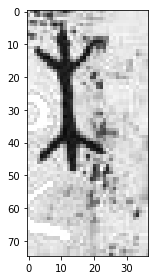

In [4]:
# 3, 5, 6, 12, 20, 28, 29
# 19, 24, 33
io.imshow(data[200])
plt.show()

# gamma correction

In [5]:
def gamma_correction(dataset, gamma):
    for image in dataset:
        yield image ** gamma

In [6]:
data_gamma = tuple(gamma_correction(data, 0.3))

In [7]:
#io.imshow(img_as_ubyte(data_gamma[200]))
#plt.show()

# Otsu thresholding

In [8]:
def otsu_threshold(dataset):
    for i in range(len(dataset)):
        image = img_as_ubyte(dataset[i])
        otsu = filters.threshold_otsu(image)
        image[image>otsu] = 255
        yield img_as_float(image)

In [9]:
data_otsu = tuple(otsu_threshold(data_gamma))

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


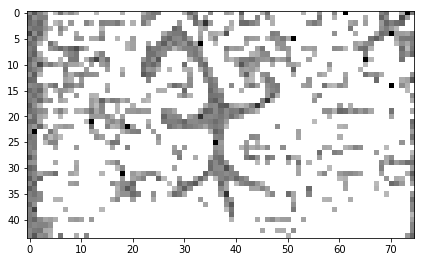

In [10]:
io.imshow(img_as_ubyte(data_otsu[50]))
plt.show()

# Histogram equalization

In [11]:
data_hist_eq = [exposure.equalize_hist(data_otsu[i]) for i in range(len(data_otsu))]

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


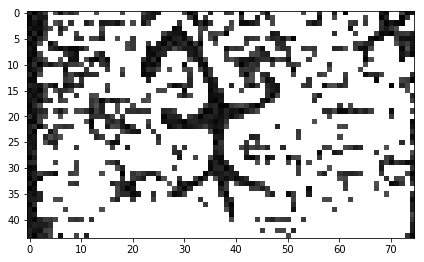

In [12]:
io.imshow(img_as_ubyte(data_hist_eq[50]))
plt.show()

# Padding

In [13]:
def split(n):
    if n%2 == 0:
        return int(n/2), int(n/2)
    return n//2, n//2+1

In [14]:
def padding(dataset):
    for image in dataset:
        if image.shape == (75,75):
            yield image
        else:
            v = 75 - image.shape[0]
            h = 75 - image.shape[1]
            top, bottom = split(v)
            left, right = split(h)
            yield cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=1)

In [15]:
data_fullsize = tuple(padding(data_hist_eq))

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


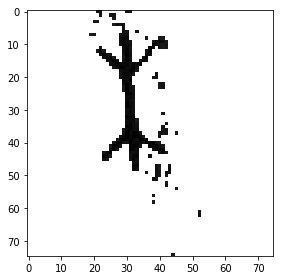

In [16]:
io.imshow(img_as_ubyte(data_fullsize[200]))
plt.show()

# denoise filter

In [17]:
def median_filter(dataset, kernal_size):
    for image in dataset:
        padded_image = np.pad(image, kernal_size//2, 'reflect')
        new_image = np.zeros((image.shape[0], image.shape[1]))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                new_image[i,j] = np.median(padded_image[i:i+kernal_size, j:j+kernal_size])
        yield new_image

In [18]:
data_denoised1 = tuple(median_filter(data_fullsize, 3))

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


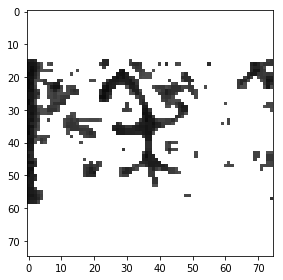

In [19]:
io.imshow(img_as_ubyte(data_denoised1[50]))
plt.show()

In [20]:
def alpha_trimmed_filter(dataset, size, d):
    for image in dataset:
        padded_image = np.pad(image, size//2, 'reflect')
        new_image = np.zeros((image.shape[0], image.shape[1]))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                lst = sorted(padded_image[i:i+size, j:j+size].reshape(size**2))
                lst = lst[d:][:-d]
                new_image[i,j] = sum(lst)/(size**2-d*2)
        yield new_image 

In [21]:
data_denoised2 = tuple(alpha_trimmed_filter(data_fullsize, 5,5))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


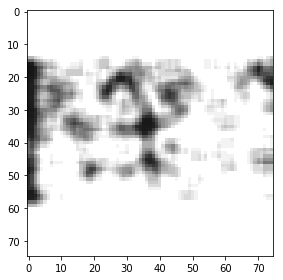

In [22]:
io.imshow(data_denoised2[50])
plt.show()

# Conbine denoised images

In [23]:
def combine(layer1, layer2, alpha):
    return layer1*alpha + layer2*(1-alpha)

In [24]:
def combine_main(dataset1, dataset2, alpha):
    assert len(dataset1) == len(dataset2)
    for i in range(len(dataset1)):
        yield combine(dataset1[i], dataset2[i], alpha)

In [25]:
data_combine = tuple(combine_main(data_denoised1, data_denoised2, 0.5))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


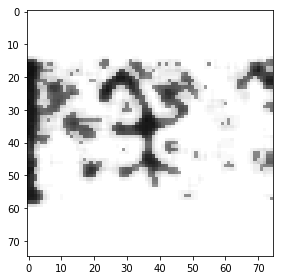

In [26]:
io.imshow(data_combine[50])
plt.show()

# Sauvola thresholding

In [27]:
def sauvola_thre(dataset, win_size):
    for image in dataset:
        thr = filters.threshold_sauvola(image, window_size=win_size)
        yield (image > thr).astype(float)

In [28]:
data_sauvola = tuple(sauvola_thre(data_combine, 75))

/anaconda/lib/python3.6/site-packages/skimage/filters/thresholding.py:777: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(g2 - m * m)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


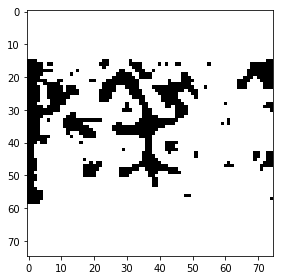

In [29]:
io.imshow(data_sauvola[50])
plt.show()

In [30]:
data_denoised3 = tuple(median_filter(data_sauvola, 3))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


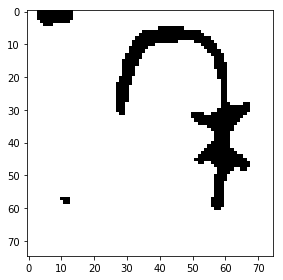

In [31]:
io.imshow(data_denoised3[0])
plt.show()

In [32]:
data_dn3_1, data_dn3_2, data_dn3_3 = data_denoised3[:78], data_denoised3[78:102], data_denoised3[102:]

# generate Artificial data - elastic_transform

http://cognitivemedium.com/assets/rmnist/Simard.pdf

In [33]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    #print(shape)
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    #print(x.shape)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

In [34]:
art_2_elastic = np.array([elastic_transform(image, alpha = 34, sigma = 4) for image in data_dn3_2])
art_2_elastic.shape

(24, 75, 75)

In [35]:
art_2_elastic[art_2_elastic>1] = 1

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


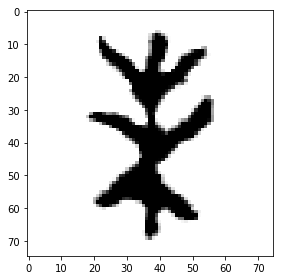

In [36]:
io.imshow(art_2_elastic[11])
plt.show()

In [37]:
np.amax(art_2_elastic[2])

1.0

# generate Artificial data - affine transformation

In [38]:
# scale = (1~1.2,1~1.2), rotation: -0.2~0.2, shear: -0.2~0.2, translation
scale = np.random.rand(len(data_dn3_2),2)/5+1
rotation = (np.random.rand(len(data_dn3_2))*2-1)/5
shear = (np.random.rand(len(data_dn3_2))*2-1)/5

In [39]:
def affine(dataset,scale, rotation, shear):
    assert len(dataset)==len(scale)==len(rotation)==len(shear)
    for i in range(len(dataset)):
        trans = AffineTransform(scale=scale[i], rotation=rotation[i], shear=shear[i])
        yield 1-(warp(1-dataset[i], trans))

In [40]:
art_2_affine = tuple(affine(data_dn3_2, scale, rotation,shear))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


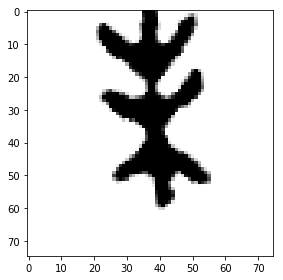

In [41]:
io.imshow(art_2_affine[11])
plt.show()

# data combination

In [42]:
all_data = list(data_dn3_1)+list(data_dn3_2)+list(art_2_elastic)+list(art_2_affine)+list(data_dn3_3)
len(all_data)

264

# Gray scale co-occurence matrix

In [43]:
# angle = [0, np.pi/4, np.pi/2, np.pi*3/4]

def gscm(dataset, angle, distance=1):
    for image in dataset:
        image = img_as_ubyte(image)
        yield greycomatrix(image, [distance], [angle])/(image.shape[0]*image.shape[1])

In [44]:
def gscm_main(dataset):
    result = []
    for gscm_matrix in dataset:
        temp = {}
        
        ent = -np.sum(gscm_matrix*np.log(gscm_matrix+0.01))
        temp['entropy'] = ent
        
        amax = np.amax(gscm_matrix)
        temp['max'] = amax
        
        range_gray = 0
        for i in range(gscm_matrix.shape[0]):
            for j in range(gscm_matrix.shape[1]):
                range_gray += gscm_matrix[i,j]/(1+abs(i-j))
        temp['range_of_gray'] = range_gray[0,0]
        
        corr = greycoprops(gscm_matrix, 'correlation')
        temp['correlation'] = corr[0,0]
        
        contrast = greycoprops(gscm_matrix, 'contrast')
        temp['contrast'] = contrast[0,0]
        
        energy = greycoprops(gscm_matrix, 'energy')
        temp['energy'] = energy[0,0]
        
        asm = greycoprops(gscm_matrix, 'ASM')
        temp['ASM'] = asm[0,0]
        
        result.append(temp)
    return result

In [45]:
data_0_1 = tuple(gscm(all_data, 0, distance=1))
data_45_1 = tuple(gscm(all_data, np.pi/4, distance=1))
data_90_1 = tuple(gscm(all_data, np.pi/2, distance=1))
data_135_1 = tuple(gscm(all_data, np.pi*3/4, distance=1))

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/lib/python3.6/site-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


In [46]:
data_0_1_result = gscm_main(data_0_1)
data_45_1_result = gscm_main(data_45_1)
data_90_1_result = gscm_main(data_90_1)
data_135_1_result = gscm_main(data_135_1)

In [47]:
gscm_features = []
for i in range(len(all_data)):
    result = list(data_0_1_result[i].values()) +\
    list(data_45_1_result[i].values()) +\
    list(data_90_1_result[i].values()) +\
    list(data_135_1_result[i].values())
    gscm_features.append(result)

In [48]:
len(gscm_features)

264

# local binary pattern

In [49]:
#local_binary_pattern(image, P, R, method='default')
def lbp(dataset, n_direction, r):
    for image in dataset:
        yield local_binary_pattern(image, n_direction, r)

In [50]:
lbp3 = tuple(lbp(all_data, 8, 1))
lbp9 = tuple(lbp(all_data, 8, 4))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


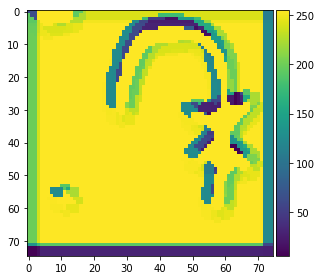

In [51]:
io.imshow(lbp9[0])
plt.show()

In [52]:
lbp3_hist = [np.histogram(lbp3[i], bins=range(256))[0] for i in range(len(lbp3))]
lbp9_hist = [np.histogram(lbp3[i], bins=range(256))[0] for i in range(len(lbp9))]

# Area

In [53]:
def area(dataset):
    for image in dataset:
        unique, counts = np.unique(image, return_counts=True)
        yield 75**2 - dict(zip(unique, counts))[1.0]

In [54]:
feat_area = tuple(area(all_data))

# Laplacian pyramid

In [55]:
def laplacian_prmd(dataset):
    for image in dataset:
        small1 = cv2.pyrDown(image)
        small2 = cv2.pyrDown(small1)
        large1 = cv2.pyrUp(small1)[:75,:75]
        large2 = cv2.pyrUp(small2)
        lap1 = image-large1
        lap2 = small1-large2
        yield small1, small2, lap1, lap2

In [56]:
laplacian_pyramid = tuple(laplacian_prmd(all_data))

In [57]:
lap_small1 = [laplacian_pyramid[i][0] for i in range(len(laplacian_pyramid))]
lap_small2 = [laplacian_pyramid[i][1] for i in range(len(laplacian_pyramid))]
lap_small3 = [laplacian_pyramid[i][2] for i in range(len(laplacian_pyramid))]
lap_small4 = [laplacian_pyramid[i][3] for i in range(len(laplacian_pyramid))]

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


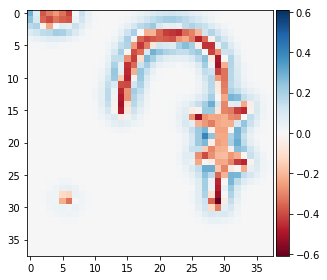

In [58]:
io.imshow(laplacian_pyramid[0][3])
plt.show()

In [59]:
def posNneg_distribution(dataset):
    for image in dataset:
        unique, counts = np.unique(image, return_counts=True)
        dic = dict(zip(unique, counts))
        pos = sum([dic[k] for k in dic.keys() if k > 0])
        neg = sum([dic[k] for k in dic.keys() if k < 0])
        zero = sum([dic[k] for k in dic.keys() if k == 0])
        yield [pos, neg, zero]

In [60]:
lap_small3_distribution_feat = tuple(posNneg_distribution(lap_small3))
lap_small4_distribution_feat = tuple(posNneg_distribution(lap_small4))

In [61]:
def all_negative(matrix):
    return np.sum(matrix < 0)

In [62]:
def all_positive(matrix):
    return np.sum(matrix > 0)

In [63]:
lap1_feat = [[all_negative(laplacian_pyramid[i][2])]+[all_positive(laplacian_pyramid[i][2])] 
             for i in range(len(all_data))]
lap2_feat = [[all_negative(laplacian_pyramid[i][3])]+[all_positive(laplacian_pyramid[i][3])] 
             for i in range(len(all_data))]

In [64]:
def neg_per_line(matrix):
    result = []
    for i in range(matrix.shape[0]):
        ct = all_negative(matrix[i])
        result.append(ct)
    return result

In [65]:
def pos_per_line(matrix):
    result = []
    for i in range(matrix.shape[0]):
        ct = all_positive(matrix[i])
        result.append(ct)
    return result

In [66]:
def feat_by_line(image):
    nh = neg_per_line(image)
    ph = pos_per_line(image)
    nv = neg_per_line(image.T)
    pv = pos_per_line(image.T)
    return nh, ph, nv, pv

In [67]:
def feat_posNneg_main(dataset):
    for image in dataset:
        result = []
        # number of non-zero values in each cols/rows
        nh, ph, nv, pv = feat_by_line(image)
        # calculate features
        # number of cols/rows which contain non-zero values
        nhn0, phn0, nvn0, pvn0 = np.count_nonzero(nh),\
        np.count_nonzero(ph), np.count_nonzero(nv), np.count_nonzero(pv)
        # mean
        result.append(np.sum(nh)/nhn0)
        result.append(np.sum(ph)/phn0)
        result.append(np.sum(nv)/nvn0)
        result.append(np.sum(pv)/pvn0)
        # standard deviation
        result.append(np.std(nh))
        result.append(np.std(ph))
        result.append(np.std(nv))
        result.append(np.std(pv))
        # smoothess: 1 - (1/(1+mean**2))
        result.append(1 - (1/(1+(np.sum(nh)/nhn0)**2)))
        result.append(1 - (1/(1+(np.sum(ph)/phn0)**2)))
        result.append(1 - (1/(1+(np.sum(nv)/nvn0)**2)))
        result.append(1 - (1/(1+(np.sum(pv)/pvn0)**2)))
        # entropy
        Pnh, Pph, Pnv, Ppv = nh/sum(nh), ph/sum(ph), nv/sum(nv), pv/sum(pv)
        result.append(np.sum([-(Pnh[i]*log(Pnh[i]+0.01)) for i in range(len(Pnh))]))
        result.append(np.sum([-(Pph[i]*log(Pph[i]+0.01)) for i in range(len(Pph))]))
        result.append(np.sum([-(Pnv[i]*log(Pnv[i]+0.01)) for i in range(len(Pnv))]))
        result.append(np.sum([-(Ppv[i]*log(Ppv[i]+0.01)) for i in range(len(Ppv))]))
        yield result

In [68]:
lap_large = [laplacian_pyramid[i][2] for i in range(len(laplacian_pyramid))]
lap_small = [laplacian_pyramid[i][3] for i in range(len(laplacian_pyramid))]

In [69]:
lap_large_feat = tuple(feat_posNneg_main(lap_large))
lap_small_feat = tuple(feat_posNneg_main(lap_small))

In [70]:
lap_large_feat[200]

[11.646153846153846,
 15.767123287671232,
 21.62857142857143,
 28.073170731707318,
 8.482410558849935,
 7.786301361294006,
 14.27835035600713,
 15.672900887271068,
 0.9926811184983214,
 0.9959936246833017,
 0.9978668719113176,
 0.9987327381751128,
 3.4896836013996513,
 3.656254626568069,
 3.092166392978707,
 3.3151402906974186]

# Sobel filter 3*3

In [71]:
def sobelH(dataset):
    for image in dataset:
        yield filters.sobel_h(image)

def sobelV(dataset):
    for image in dataset:
        yield filters.sobel_v(image)

def sobelSqrt(dataset):
    for image in dataset:
        yield filters.sobel(image)

In [72]:
sb_h, sb_v, sb_sqrt = tuple(sobelH(all_data)), tuple(sobelV(all_data)), tuple(sobelSqrt(all_data))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


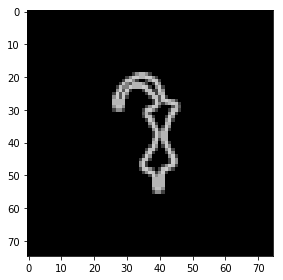

In [73]:
io.imshow(sb_sqrt[21])
plt.show()

In [74]:
sobel_sum = [np.count_nonzero(image) for image in sb_sqrt]
sobel_h_distribution = tuple(posNneg_distribution(sb_h))
sobel_v_distribution = tuple(posNneg_distribution(sb_v))

# Roberts filter (diagonal)

In [75]:
def robertsP(dataset):
    for image in dataset:
        yield (filters.roberts_pos_diag(image))

def robertsN(dataset):
    for image in dataset:
        yield (filters.roberts_neg_diag(image))

def robertsPSqrt(dataset):
    for image in dataset:
        yield (filters.roberts(image))

In [76]:
rt_p, rt_n, rt_sqrt = tuple(robertsP(all_data)), tuple(robertsN(all_data)), tuple(robertsPSqrt(all_data))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


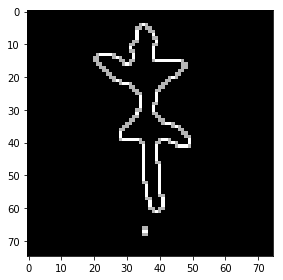

In [77]:
io.imshow(rt_sqrt[250])
plt.show()

In [78]:
rt_sum = [np.count_nonzero(image) for image in rt_sqrt]
rt_p_distribution = tuple(posNneg_distribution(rt_p))
rt_n_distribution = tuple(posNneg_distribution(rt_n))

# Laplace filter

In [79]:
def _mask_filter_result(result):
    """Return result after masking.
    Input masks are eroded so that mask areas in the original image don't
    affect values in the result.
    """
    result[0, :] = 0
    result[-1, :] = 0
    result[:, 0] = 0
    result[:, -1] = 0
    return result

In [80]:
def Lap(image, l_matrix):
    image = img_as_float(image)
    result = convolve(image, l_matrix)
    result = _mask_filter_result(result)
    b,s = 1/np.amax(result), 1/abs(np.amin(result))
    result[result<0] *= s
    result[result>0] *= b
    return result

In [81]:
def lap_main(dataset,l_matrix):
    for image in dataset:
        yield (Lap(image, l_matrix))

In [82]:
l = np.array([[0,0,-1,0,0], [0,-1,-2,-1,0], [-1,-2,16,-2,-1], [0,-1,-2,-1,0], [0,0,-1,0,0]])

In [83]:
lap = tuple(lap_main(all_data, l))

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


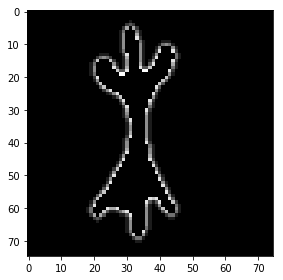

In [84]:
io.imshow(img_as_ubyte(lap[202]))
plt.show()

# corner detection

In [85]:
def harris(dataset):
    for image in dataset:
        feat = corner_harris(image, k=0.1)
        feat[np.abs(feat)<2] = 0
        yield feat[3:72, 3:72]

In [86]:
corner = tuple(harris(all_data))

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


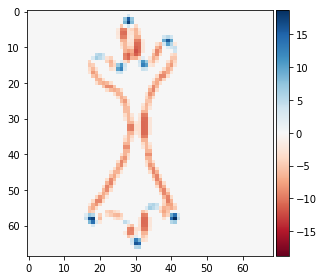

In [87]:
io.imshow(corner[202])
plt.show()

In [88]:
harris_distribution_feat = tuple(posNneg_distribution(corner))

In [89]:
ncn = [all_negative(corner[i]) for i in range(len(corner))]
pcn = [all_positive(corner[i]) for i in range(len(corner))]

In [90]:
corner_feat = tuple(feat_posNneg_main(corner))

In [91]:
corner_feat[0]

[8.875,
 5.095238095238095,
 9.94,
 3.566666666666667,
 6.003814512445648,
 2.7480492785281476,
 7.607356679975951,
 2.157133308949957,
 0.9874632713026444,
 0.962910008410429,
 0.9899803213511337,
 0.9271196048263017,
 3.4227323679534223,
 2.712501645501951,
 3.294549253527408,
 3.0124548315945607]

# Filter banks

In [92]:
h0 = np.array([0.5, 0.5])
h1 = np.array([0.5, -0.5])

In [93]:
def filter_banks(image):
    L = np.array([np.convolve(image[i], h0) for i in range(image.shape[0])][::2])
    H = np.array([np.convolve(image[i], h1) for i in range(image.shape[0])][::2])
    LL = np.array([np.convolve(L.T[i], h0) for i in range(image.shape[1])][::2]).T
    LH = np.array([np.convolve(L.T[i], h1) for i in range(image.shape[1])][::2]).T
    HL = np.array([np.convolve(H.T[i], h0) for i in range(image.shape[1])][::2]).T
    HH = np.array([np.convolve(H.T[i], h1) for i in range(image.shape[1])][::2]).T
    return LL, LH, HL, HH

In [94]:
LL, LH, HL, HH = [], [], [], []
for image in all_data:
    ll, lh, hl, hh = filter_banks(image)
    LL.append(ll)
    LH.append(lh)
    HL.append(hl)
    HH.append(hh)

/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


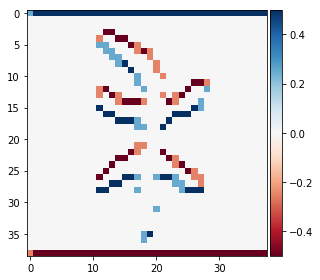

In [95]:
io.imshow(LH[200])
plt.show()

In [96]:
HL_distribution_feat = tuple(posNneg_distribution(HL))
LH_distribution_feat = tuple(posNneg_distribution(LH))
HH_distribution_feat = tuple(posNneg_distribution(HH))

# horizontal and vertical info

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


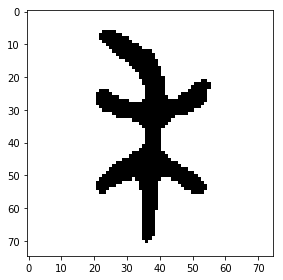

In [97]:
io.imshow(img_as_ubyte(all_data[200]))
plt.show()

In [98]:
def pixels_per_line(matrix):
    result = []
    for i in range(matrix.shape[0]):
        ct = np.count_nonzero(1-matrix[i])
        result.append(ct)
    return result

In [99]:
def pixel_count(image):
    h = pixels_per_line(image)
    v = pixels_per_line(image.T)
    return h,v

In [100]:
def std(array):
    array = list(filter(lambda a: a != 0, array))
    return np.std(array)

In [101]:
def greater_than_half(array):
    assert(np.amax(array) == 1 and np.amin(array) >= 0)
    array = list(filter(lambda a: a > 0.5, array))
    return len(array)

In [102]:
def less_than_half(array):
    assert(np.amax(array) == 1 and np.amin(array) >= 0)
    array = list(filter(lambda a: a < 0.5 and a > 0, array))
    return len(array)

In [103]:
def ent_by_line(image):
    result = []
    for i in range(image.shape[0]):
        rev = img_as_ubyte(1-image)
        probDic = FreqDist(rev[i])
        probDic = {k:v/len(image[i]) for k,v in probDic.items()}
        prob = [probDic[pixel] for pixel in rev[i]]
        ent = sum([-p*log(p) for p in prob])
        result.append(ent)
    return sorted(result, reverse=True)

In [104]:
def ent_by_line_main(image):
    ent_h = ent_by_line(image)
    ent_v = ent_by_line(image.T)
    return ent_h, ent_v

In [105]:
# read images of black(0) background and lighter color as character (non-zero)
# used for original image/down-sampled image

def feat_main(dataset):
    for image in dataset:
        result = []
        h,v = pixel_count(image)

        # calculate features
        hn0, vn0 = np.count_nonzero(h), np.count_nonzero(v)

        # mean
        result.append(sum(h)/hn0)
        result.append(sum(v)/vn0)

        # standard deviation
        result.append(std(h))
        result.append(std(v))

        # smoothess: 1 - (1/(1+mean**2))
        result.append(1 - (1/(1+(sum(h)/hn0)**2)))
        result.append(1 - (1/(1+(sum(v)/vn0)**2)))

        # entropy
        Ph, Pv = np.array(h)/sum(h), np.array(v)/sum(v)
        result.append(sum([-(Ph[i]*log(Ph[i]+0.01)) for i in range(len(Ph))]))
        result.append(sum([-(Pv[i]*log(Pv[i]+0.01)) for i in range(len(Pv))]))

        # count non-zero pixels
        max_h, max_v = max(h), max(v)
        result.append(max_h)
        result.append(max_v)

        # rank non-zero pixels
        sorted_h = sorted(list(np.array(h)/max_h))[::-1]
        sorted_v = sorted(list(np.array(v)/max_v))[::-1]

        # mean, std of sorted prob
        result.append(sum(sorted_h)/hn0)
        result.append(sum(sorted_v)/vn0)
        result.append(std(sorted_h))
        result.append(std(sorted_v))
        greater_ratio_h, greater_ratio_v = greater_than_half(sorted_h)/hn0, greater_than_half(sorted_v)/vn0
        result.append(greater_ratio_h)
        result.append(greater_ratio_v)
        
        # mean, std of ent_by_line
        ent_h, ent_v = ent_by_line_main(image)
        ent_hn0, ent_vn0 = np.count_nonzero(ent_h), np.count_nonzero(ent_v)
        ent_h_mean, ent_v_mean = sum(ent_h)/ent_hn0, sum(ent_v)/ent_vn0
        ent_h_std, ent_v_std = std(ent_h), std(ent_v)
        result.append(np.amax(ent_h))
        result.append(np.amax(ent_v))
        result.append(ent_h_mean)
        result.append(ent_v_mean)
        result.append(ent_h_std)
        result.append(ent_v_std)
        
        yield result

In [106]:
sb_sqrt_rev = [1-image for image in sb_sqrt]
rt_sqrt_rev = [1-image for image in rt_sqrt]

In [107]:
feat_all_data = tuple(feat_main(all_data))
feat_lap_small1 = tuple(feat_main(lap_small1))
feat_lap_small2 = tuple(feat_main(lap_small2))

feat_sobel_h = tuple(feat_posNneg_main(sb_h))
feat_sobel_v = tuple(feat_posNneg_main(sb_v))
feat_sobel_sqrt = tuple(feat_main(sb_sqrt_rev))

feat_roberts_p = tuple(feat_posNneg_main(rt_p))
feat_roberts_n = tuple(feat_posNneg_main(rt_n))
feat_roberts_sqrt = tuple(feat_main(rt_sqrt_rev))

/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [108]:
# gscm_features, lbp_hist, lap_large_feat, lap_small_feat, corner_feat
# feat_otsu2, feat_lap_small1, feat_lap_small2
# feat_sobel_h, feat_sobel_v, feat_sobel_sqrt
# feat_roberts_p, feat_roberts_n, feat_roberts_sqrt

In [109]:
feat = []
for i in range(len(all_data)):
    feat.append([])
    feat[i].append(gscm_features[i])
    feat[i].append(lbp3_hist[i])
    feat[i].append(lbp9_hist[i])
    feat[i].append(lap_large_feat[i])
    feat[i].append(lap_small_feat[i])
    feat[i].append(feat_all_data[i])
    feat[i].append(feat_lap_small1[i])
    feat[i].append(feat_lap_small2[i])
    feat[i].append(sobel_h_distribution[i])
    feat[i].append(sobel_v_distribution[i])
    feat[i].append(feat_sobel_h[i])
    feat[i].append(feat_sobel_v[i])
    feat[i].append(feat_sobel_sqrt[i])
    feat[i].append(rt_p_distribution[i])
    feat[i].append(rt_n_distribution[i])
    feat[i].append(feat_roberts_p[i])
    feat[i].append(feat_roberts_n[i])
    feat[i].append(feat_roberts_sqrt[i])
    feat[i].append([feat_area[i]])
    feat[i].append([sobel_sum[i]])
    feat[i].append([rt_sum[i]])
    feat[i].append(harris_distribution_feat[i])
    feat[i].append(lap_small3_distribution_feat[i])
    feat[i].append(lap_small4_distribution_feat[i])
    feat[i].append(HL_distribution_feat[i])
    feat[i].append(LH_distribution_feat[i])
    feat[i].append(HH_distribution_feat[i])

In [110]:
for i in range(len(feat)):
    feat[i] = list(itertools.chain.from_iterable(feat[i]))

In [111]:
feat = np.array(feat)
feat.shape

(264, 777)

In [112]:
# 78, 72, 114
label = np.concatenate((np.repeat(0,78), np.repeat(1,72), np.repeat(2,114)), axis=0)

In [113]:
X_test, y_test = feat[::5], label[::5]
X_train = [feat[i].astype(float) for i in range(len(feat)) if i%5 != 0]
y_train = [label[i] for i in range(len(label)) if i%5 != 0]

In [114]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [115]:
pred = clf.predict(X_test)

In [116]:
pd.DataFrame(confusion_matrix(y_test, pred), 
             columns=['pred_1', 'pred_2', 'pred_3'], index=['class_1', 'class_2', 'class_3'])

,pred_1,pred_2,pred_3
class_1,3,0,13
class_2,1,8,5
class_3,1,0,22


In [117]:
precision_score(y_test, pred, average='macro')

0.7166666666666668

In [118]:
recall_score(y_test, pred, average='macro')

0.5718167701863354

In [119]:
f1_score(y_test, pred, average='macro')

0.5704665704665706

In [120]:
clf.score(X_test, y_test)

0.6226415094339622

# baseline - dummy classifier

In [121]:
clf_dummy = DummyClassifier(strategy='most_frequent', random_state=0)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test) 

0.4339622641509434

# Improving the model - Feature Reduction

In [122]:
fit = SelectKBest(chi2, k=41).fit(feat, label)
feat_new = fit.transform(feat)

In [123]:
scores = sorted(fit.scores_[~np.isnan(fit.scores_)], reverse=True)

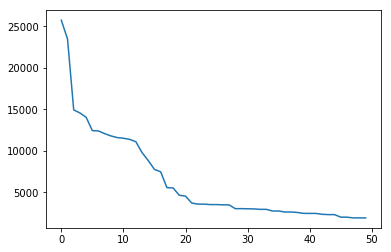

In [124]:
plt.plot(range(50), scores[:50])
plt.show()

In [125]:
feat_new.shape

(264, 41)

In [126]:
X_test_new = feat_new[::5]
X_train_new = [feat_new[i].astype(float) for i in range(len(feat_new)) if i%5 != 0]

In [127]:
clf_new = LinearSVC()
clf_new.fit(X_train_new, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [128]:
pred_new = clf_new.predict(X_test_new)

In [129]:
pd.DataFrame(confusion_matrix(y_test, pred_new), 
             columns=['pred_1', 'pred_2', 'pred_3'], index=['class_1', 'class_2', 'class_3'])

,pred_1,pred_2,pred_3
class_1,9,2,5
class_2,2,10,2
class_3,3,0,20


In [130]:
precision_score(y_test, pred_new, average='macro')

0.7389770723104055

In [131]:
recall_score(y_test, pred_new, average='macro')

0.7154503105590062

In [132]:
f1_score(y_test, pred_new, average='macro')

0.7230769230769231

# Feature Reduction - PCA

In [133]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(feat)

In [134]:
pca.explained_variance_ratio_

array([0.83624277, 0.13064879])

In [135]:
X_test_pca = pca_feat[::5]
X_train_pca = [pca_feat[i] for i in range(len(pca_feat)) if i%5 != 0]

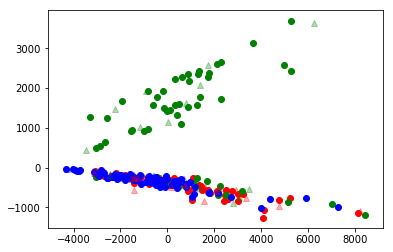

In [136]:
# train: 62, 120
# test: 16, 30
x1, x2, x3 = np.array(X_train_pca)[:62,0], np.array(X_train_pca)[62:120,0], np.array(X_train_pca)[120:,0]
y1, y2, y3 = np.array(X_train_pca)[:62,1], np.array(X_train_pca)[62:120,1], np.array(X_train_pca)[120:,1]
x4, x5, x6 = np.array(X_test_pca)[:16,0], np.array(X_test_pca)[16:30,0], np.array(X_test_pca)[30:,0]
y4, y5, y6 = np.array(X_test_pca)[:16,1], np.array(X_test_pca)[16:30,1], np.array(X_test_pca)[30:,1]
plt.scatter(x1, y1, c='r')
plt.scatter(x2, y2, c='g')
plt.scatter(x3, y3, c='b')
plt.scatter(x4, y4, c='r', marker='^', alpha=0.3)
plt.scatter(x5, y5, c='g', marker='^', alpha=0.3)
plt.scatter(x6, y6, c='b', marker='^', alpha=0.3)
plt.show()

In [137]:
clf_pca = LinearSVC()
clf_pca.fit(X_train_pca, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [138]:
pred_pca = clf_pca.predict(X_test_pca)

In [139]:
pd.DataFrame(confusion_matrix(y_test, pred_pca), 
             columns=['pred_1', 'pred_2', 'pred_3'], index=['class_1', 'class_2', 'class_3'])

,pred_1,pred_2,pred_3
class_1,7,9,0
class_2,2,5,7
class_3,22,1,0


In [140]:
precision_score(y_test, pred_pca, average='macro')

0.18637992831541217

In [141]:
recall_score(y_test, pred_pca, average='macro')

0.2648809523809524

In [142]:
f1_score(y_test, pred_pca, average='macro')

0.21423330887747616

# Leave-one-out

In [143]:
loo = LeaveOneOut()

In [144]:
acc = []
for train_index, test_index in loo.split(feat):
    X_train_one, X_test_one = feat[train_index], feat[test_index]
    y_train_one, y_test_one = label[train_index], label[test_index]
    
    clf_one = LinearSVC()
    clf_one.fit(X_train_one, y_train_one)
    pred_one = clf_one.predict(X_test_one)
    
    acc.append(precision_score(y_test_one, pred_one, average='macro'))

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [145]:
sum(acc)/len(acc)

0.6363636363636364

In [146]:
acc_new = []
for train_index, test_index in loo.split(feat_new):
    X_train_one_new, X_test_one_new = feat_new[train_index], feat_new[test_index]
    y_train_one, y_test_one = label[train_index], label[test_index]
    
    clf_one = LinearSVC()
    clf_one.fit(X_train_one_new, y_train_one)
    pred_one = clf_one.predict(X_test_one_new)
    
    acc_new.append(precision_score(y_test_one, pred_one, average='macro'))

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [147]:
sum(acc_new)/len(acc_new)

0.6174242424242424

In [148]:
acc_pca = []
for train_index, test_index in loo.split(pca_feat):
    X_train_one_pca, X_test_one_pca = pca_feat[train_index], pca_feat[test_index]
    y_train_one, y_test_one = label[train_index], label[test_index]
    
    clf_one = LinearSVC()
    clf_one.fit(X_train_one_pca, y_train_one)
    pred_one = clf_one.predict(X_test_one_pca)
    
    acc_pca.append(precision_score(y_test_one, pred_one, average='macro'))

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [149]:
sum(acc_pca)/len(acc_pca)

0.49242424242424243